In [15]:
import os
import argparse
import torch
import numpy as np
from models import build_model
from utils import get_dataset, backdoor_train, backdoor_evaluate, validation_per_class
from poisoned_dataset import create_backdoor_data_loader
import matplotlib.pyplot as plt

In [2]:
class args():
    dir = './'
    dataname = 'mnist'
    seed = 1
    epsilon = 0.1
    source_label=0
    target_label=1
    epsilons=[0.1]

In [11]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)

def calc_cad(server_acc, backdoored_clean_per_class):
    backdoored_acc = (backdoored_clean_per_class.diag()/backdoored_clean_per_class.sum(1)).mean()
    cad = server_acc-backdoored_acc
    return cad

def calc_asr(confusion_matrix):
    successful_attacks = confusion_matrix[args.source_label, args.target_label]
    all_attacks = confusion_matrix[args.source_label,:].sum()
    asr = successful_attacks/all_attacks
    return asr

data_dir = os.path.join(args.dir, 'data')
results_dir = os.path.join(args.dir, 'results')

path = os.path.join(
    results_dir, f'{args.dataname}_server_results.pt')
server_model = torch.load(path, weights_only=False)
server_acc = server_model['acc'][0]/100

backdoored_cads = []
backdoored_asrs = []
personalized_cads = []
personalized_asrs = []

for epsilon in args.epsilons:
    path = os.path.join(
            results_dir, f'{args.dataname}_{args.epsilon}_{args.source_label}->{args.target_label}_backdoor_results.pt')
    backdoored_model  = torch.load(path, weights_only=False)

    backdoored_clean_per_class = backdoored_model['clean_per_class']
    backdoored_poisoned_per_class = backdoored_model['poisoned_per_class']

    path = os.path.join(
        results_dir, f'{args.dataname}_{args.epsilon}_{args.source_label}->{args.target_label}_finetuned_results.pt')
    personalized_model = torch.load(path, weights_only=False)

    backdoored_asr = backdoored_model['asr']
    personalized_asr = personalized_model['asr']

    backdoored_acc = backdoored_model['test_acc'][-1]
    personalized_acc = personalized_model['test_acc']

    backdoored_cad = server_acc-backdoored_acc
    personalized_cad = server_acc-personalized_acc

    backdoored_cads.append(backdoored_cad)
    backdoored_asrs.append(backdoored_asr)
    personalized_cads.append(personalized_cad)
    personalized_asrs.append(personalized_asr)

backdoored_cads

[0.04300000000000004]

In [12]:
backdoored_asrs

[tensor(0.9972)]

In [13]:
personalized_asrs

[tensor(0.9216)]

In [14]:
personalized_cads

[0.011199999999999988]

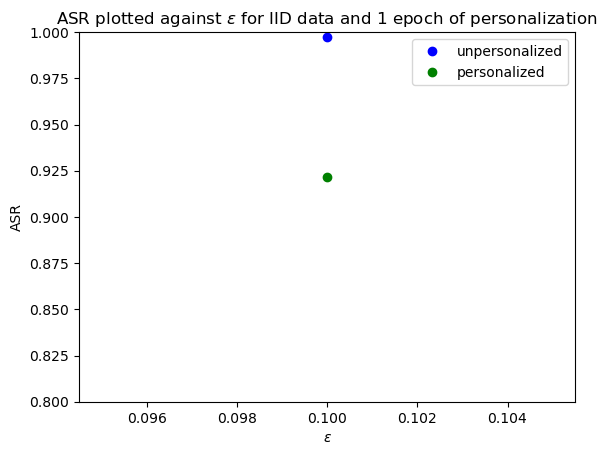

In [28]:
plt.figure()
plt.plot(args.epsilons, backdoored_asrs, 'bo', label='unpersonalized')
plt.plot(args.epsilons, personalized_asrs, 'go', label='personalized')
plt.legend()
plt.ylim((0.8,1))
plt.xlabel('$\epsilon$')
plt.ylabel('ASR')
plt.title('ASR plotted against $\epsilon$ for IID data and 1 epoch of personalization')
plt.show()